# Predictive Modeling of Urban Blight in Detroit with a Scaleable Machine Learning Workflow
### A Capstone Project for the [Data Science at Scale Specialization](https://www.coursera.org/specializations/data-science) from the University of Washington via Coursera
## by Nate Betz / [LinkedIn](http://www.linkedin.com/in/nbetz) / [Twitter](http://www.twitter.com/quantability)
#### May 9th, 2016

The objective of this project is to predict building abandonment (“blight”) based on a number of public datasets, 
including criminal incidents, permit violations, and more. This project grew out of a roundtable discussion with 
Socrata and city analytics leaders in Detroit, Kansas City, New Orleans, Boston, and more --- these cities shared 
a common interest in being proactive about identifying buildings at risk for abandonment and taking steps to prevent
the harms that arise as a result. UW/Coursera conducted an initial analysis to check the feasibility of the project, 
but it remains largely an unsolved problem. Solutions will have a chance to be deployed in practice and impact city policy.

Some of the techniques and tools utilized in this project:
    
* Geospatial density clustering for building definitions and event proximity
* Machine Learning
    - XGBoost - a fast and accurate boosted decison tree learning algorithm
    - Scikit-learn - Python wrapper framework for ML
    - Feature engineering 
    - Parameter optimization via grid search with 5-fold cross validation
* MongoDB 
    - Used for data persistance, geospatial indexing and fast querying
* Data Visualizations
    - Bokeh / Google Maps
    - Feature Importance
    - Data Profile Reporting
* Predictive Modeling Workflow
    - I'm continually refining my ML workflow, but some enhanced elements include the persistance of all parameters
    and metrics for each iteration of a model into a NoSQL database.  This allows you to measure incremental improvements
    and link them to specific changes.  As I incorporate additional ML algorithms in the framework, I expect this will
    also become a powerful ensembling tool.
    - As a data scientist with a software engineering background, I try to build analytics workflows with reusable 
    patterns and encapsulated, individually testable code modules in a continuously refined framework.
* Scaleability
    - The use of AWS EC2 for compute resources combined with S3-backed MongoDB for data persistence provides a framework 
    for a highly scaleable solution for larger datasets.

#### Results:
    
My current best AUC score for this project is **0.835094**, which I feel is a reasonably good model given the particular
problem being studied, my limited experience with the domain, and time constraints. My expectation is that model accuracy
could be improved by further iterations of feature engineering, tuning, and ensembling.

I plan to make full source code available on [GitHub](https://github.com/quantability/UW-DataSci-Capstone) soon, after I have a chance to clean some
things up.

### Initial data loading/munging phase.

Load all data from flat files into memory, perform cleaning and validation operations, and persist our
conditioned data in a NoSQL datastore.  

Iterate though all data and construct a dataset of unique building locations using the *building_extent_radius_meters* 
variable below to define the geospherical extent of each location.  If a recorded event is geocoded within that radius
of an existing location, it will be tied to that building, otherwise a new building location will be created.

Use our demolition permit records to apply a ground truth Abandoned label to applicable locations.

Four source data files were used in this project:

* detroit-blight-violations.csv : Each record is a blight violation incident.
* detroit-demolition-permits.tsv: Each record represents a permit for a demolition.
* detroit-311.csv: Each record represents a 311 call, typically a complaint.
* detroit-crime.csv: Each record represents a criminal incident.

In [84]:
import timeit
import pandas as pd
import dss_capstone_library as lib

# Get a reference to our MongoDB instance
db = lib.get_db()

building_extent_radius_meters = 35

# Uncomment the next line to delete all persisted data and re-initialize our MongoDB
lib.reset_db()

if db.buildings.find({}).count() == 0:
    lib.load_and_cleanse_source_data()
    loc_df = lib.create_combined_geolocation_df()
    lib.load_source_df_to_mongodb()
    lib.populate_buildings_collection(loc_df, building_extent_radius_meters)   
    lib.apply_ground_truth_labels()
    

307804 blight violation records loaded from CSV.
19680 311 call records loaded from CSV.
119931 crime report records loaded from CSV.
7133 demolition permit records loaded from TSV.
222366 unique geolocation coordinates validated.
67061 building records created of extent size 35 meters.
4153 buildings labeled as abandoned (prediction_label = 1)
62908 buildings labeled as not abandoned (prediction_label = 0)


#### Figure 1: Geographical Plot of Abandoned Buildings

Each red dot identifies the locaiton of an abandoned building record in our data.

In [2]:
from IPython.display import IFrame
from dss_capstone_library import to_df
unique_locs_permits = to_df(db.permits.find({'is_valid': True})).loc[:,['lat', 'lng', 'is_valid']].drop_duplicates()
lib.draw_gmap(unique_locs_permits, "red", "gmap_plot_detroit_dismantle_permits.html", 11)
IFrame("gmap_plot_detroit_dismantle_permits.html", width=700, height=700)

### Create dataset for model training and testing

Create our training/test dataset consisting of a 50-50 split of each label value.  We include all our abandoned buildings 
and an equal number of randomly sampled buildings that are not currently identified as abandoned.

Build all of our custom features, relying heavily on MongoDB's geospatial proximity searches to identify nearby event records.

In [90]:
from datetime import datetime

# Uncomment the next line to rebuild the training/test data set
#db.training_data.delete_many({})
# Otherwise this step is skipped if the dataset has already been built
if db.training_data.find({}).count() == 0:
    lib.initialize_and_label_training_data()

def add_all_features():
    start_time = timeit.default_timer()
    result = db.training_data.find({})
    for bldg in result:
        lat = bldg['loc']['coordinates'][1]
        lng = bldg['loc']['coordinates'][0]
        add_feature(bldg, 'c_blight_1000m', "Count of all blight violations within 1000 meters",
                    lambda: get_event_count(db.blight, lat, lng, 1000))
        add_feature(bldg, 'c_blight_100m', "Count of all blight violations within 100 meters",
                    lambda: get_event_count(db.blight, lat, lng, 100))
        add_feature(bldg, 'c_blight_35m', "Count of all blight violations within 35 meters",
                    lambda: get_event_count(db.blight, lat, lng, 35))
        add_feature(bldg, 'c_311_1000m', "Count of all 311 calls within 1000 meters",
                    lambda: get_event_count(db.calls311, lat, lng, 1000))
        add_feature(bldg, 'c_311_100m', "Count of all 311 calls within 100 meters",
                    lambda: get_event_count(db.calls311, lat, lng, 100))
        add_feature(bldg, 'c_311_35m', "Count of all 311 calls within 35 meters",
                    lambda: get_event_count(db.calls311, lat, lng, 35))
        add_feature(bldg, 'c_crime_1000m', "Count of all crime reports within 1000 meters",
                    lambda: get_event_count(db.crime, lat, lng, 1000))
        add_feature(bldg, 'c_crime_100m', "Count of all crime reports within 100 meters",
                    lambda: get_event_count(db.crime, lat, lng, 100))
        add_feature(bldg, 'c_crime_35m', "Count of all crime reports within 35 meters",
                    lambda: get_event_count(db.crime, lat, lng, 35))
        add_feature(bldg, 'c_permits_1000m', "Count of all dismantle permits issued within 1000 meters",
                    lambda: get_event_count(db.permits, lat, lng, 1000))
        add_feature(bldg, 'c_permits_100m', "Count of all dismantle permits issued within 100 meters",
                    lambda: get_event_count(db.permits, lat, lng, 100))
        add_feature(bldg, 'c_unpaid_blight_35m', "Count of all unpaid blight violations within 35 meters",
                    lambda:  get_event_cursor(db.blight, lat, lng, 35, 
                            {'is_valid': True, 'PaymentStatus': {'$eq': 'NO PAYMENT APPLIED'}} ).count())
        add_feature(bldg, 'c_open_311_35m', "Count of all open 311 calls within 35 meters",
                    lambda:  get_event_cursor(db.calls311, lat, lng, 35, 
                            {'is_valid': True, 'ticket_status': {'$ne': 'Closed'}} ).count())
        add_feature(bldg, 'c_recent_311_100m', "Count of recent 311 calls within 100 meters",
                    lambda:  get_event_cursor(db.calls311, lat, lng, 100, 
                            {'is_valid': True, 'ticket_created_date_time': { '$gte' : datetime(2015, 1, 1) }} ).count())
        add_feature(bldg, 'c_recent_crime_100m', "Count of recent crime reports within 100 meters",
                    lambda:  get_event_cursor(db.crime, lat, lng, 35, 
                            {'is_valid': True, 'INCIDENTDATE': { '$gte' : datetime(2015, 6, 1) }} ).count())

    print "Featurization completed in " + str(timeit.default_timer() - start_time) + " seconds."
                
# Apply all of our features to the training/test data
add_all_features()

# Extract our training/test dataset from the DB to an in-memory dataframe
df_train =  lib.get_training_df(db.training_data)

Featurization completed in 45.9733388424 seconds.


### Generate data profile report of our newly created training data set with features.

In [91]:
from pandas_profiling import ProfileReport
ProfileReport(df_train)

Number of variables,19
Number of observations,8306
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,152.0 B
Numeric,16
Categorical,0
Date,0
Text (Unique),0
Rejected,3
Distinct count,971


### Machine Learning

Perform a gridsearch using scikit-learn and 5-fold cross validation to help identify a best set of learning parameters.

Use our optimized parameters with XGBoost to train our model.  Use early stopping and real-time evaluation metrics to 
try to find our best model.

Save our model, all parameters, and metrics in our NoSQL database for later analysis, tuning, and potential ensembling.

In [104]:
# model_params = hierarchical dictionary of generalized and algo-specific parameters
model_params = {
    'algo': 'xgboost',
    'xgb_params_test':
                { 'nthread':[4], 
                  'objective':['binary:logistic'],
                  'learning_rate': [0.03,0.1], 
                  'max_depth': [3,5,8],
                  'min_child_weight': [1],
                  'silent': [1],
                  'subsample': [0.8,1.0],
                  'colsample_bytree': [0.8,1.0],
                  'reg_alpha': [0.01, 0.05],
                  'n_estimators': [100], 
                  'seed': [1971]},
    'key_col': 'sequence_id', 
    'label_col': 'prediction_label',
    'num_rounds': 500, 
    'early_stopping_rounds': 30,
    'test_sample_percent': .1,
}
model_params['features'] = [col for col in df_train.columns 
                            if col not in [model_params['key_col'], model_params['label_col']]]

if not model_params.has_key('xgb_params_best'):
    if not 'best_parameters' in vars():
        best_parameters, score, clf = lib.do_gridsearch_cv(model_params, df_train)
    model_params['xgb_params_best'] = best_parameters
    model_params['xgb_params_best']['eval_metric'] = 'auc'

# Train our predictive model using XGBoost
# Returns:
#     model object
#     metrics related to model prediction accuracy
xgb_model, metrics = lib.train_xgb(model_params, df_train)

# save all metrics, parameters, etc. of model to our db for later analysis/tuning
model_id = lib.save_model(df_train, model_params, metrics, xgb_model, True)


{'algo': 'xgboost',
 'early_stopping_rounds': 30,
 'features': [u'c_311_1000m',
              u'c_311_100m',
              u'c_311_35m',
              u'c_blight_1000m',
              u'c_blight_100m',
              u'c_blight_35m',
              u'c_crime_1000m',
              u'c_crime_100m',
              u'c_crime_35m',
              u'c_open_311_35m',
              u'c_permits_1000m',
              u'c_permits_100m',
              u'c_recent_311_100m',
              u'c_recent_crime_100m',
              u'c_unpaid_blight_35m',
              'lat',
              'lng'],
 'key_col': 'sequence_id',
 'label_col': 'prediction_label',
 'num_rounds': 500,
 'test_sample_percent': 0.1,
 'xgb_params_best': {'colsample_bytree': 1.0,
                     'eval_metric': 'auc',
                     'learning_rate': 0.03,
                     'max_depth': 5,
                     'min_child_weight': 1,
                     'n_estimators': 100,
                     'nthread': 2,
                  

#### Figure 2: Feature Importance Visualization

<IPython.core.display.Javascript object>


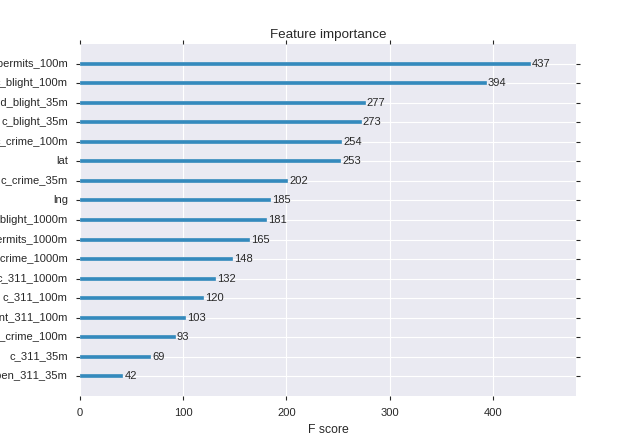

In [94]:
%matplotlib nbagg
import xgboost as xgb
xgb.plot_importance(xgb_model)

#### Figure 3: Decision Tree Visualization

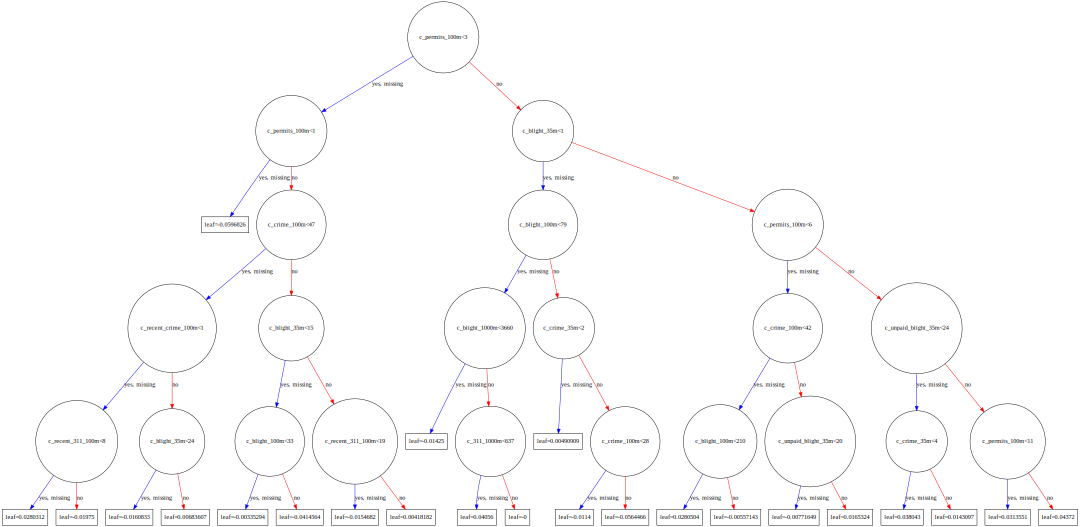

In [100]:
xgb.to_graphviz(xgb_model, size="15,15")

### Characteristics of Our Current Best Model

In [93]:
lib.print_best_model(db.predictive_models)

The AUC score of the current best model is: 0.835094

{u'_id': ObjectId('5730a22f03848821be7b68ee'),
 u'lastModified': datetime.datetime(2016, 5, 9, 16, 52, 26, 353000),
 u'metrics': {u'best_iteration': 157,
              u'best_ntree_limit': 158,
              u'best_score': 0.835094},
 u'model_id': 1,
 u'model_params': {u'algo': u'xgboost',
                   u'early_stopping_rounds': 30,
                   u'features': [u'c_311_1000m',
                                 u'c_311_100m',
                                 u'c_311_35m',
                                 u'c_blight_1000m',
                                 u'c_blight_100m',
                                 u'c_blight_35m',
                                 u'c_crime_1000m',
                                 u'c_crime_100m',
                                 u'c_crime_35m',
                                 u'c_open_311_35m',
                                 u'c_permits_1000m',
                                 u'c_permits_100m',
  

### Generate Prediction Values

In [101]:
# generate our prediction scores using the best model
predictions = xgb_model.predict(lib.df_to_matrix(df_train, 
                                model_params['key_col'], 
                                model_params['label_col']), 
                                ntree_limit=metrics['best_ntree_limit'])

submission = pd.DataFrame({ 'id': df_train['sequence_id'], 'prediction': predictions })
submission

,id,prediction
0,10,0.803386
1,11,0.789472
2,12,0.753142
3,16,0.559927
4,23,0.796823
5,24,0.689231
6,57,0.868831
7,87,0.745428
8,97,0.800976
9,103,0.855879
